# Оценка корректности проведения А/В теста по эффективности новой рекомендательной системы

Цель нашего исследования - оценить корректность проведения теста, и выявить эффект от новой рекомендательной системы на конверсию. У нас есть ТЗ проведенного теста, и датасеты со всеми событиями, касающиеся теста.

В рамках анализа необходимо:
- проверить пересечение нашей базы с базой конкурирующего теста
- проверить равномерность распределения пользователей по тестовым группам на каждом этапе воронки
- оценить, как меняется конверсия на каждом этапе воронки

**План работы**

- ознакомление с данными
- проверка на пропуски и дубликаты
- проверка данных на соответствие к тз
- исследование аб теста
- анализ воронки, конверсии
- проверка на стат значимые разницы
- выводы


In [1]:
# загружаем библиотеки

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


import math
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

## Ознакомление с данными, предобработка

In [2]:
# загружаем все данные

df_ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
df_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
df_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
df_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [3]:
# обзор данных

df_list = [df_ab_events, df_marketing_events, df_new_users, df_participants]
names = ['df_ab_events', 'df_marketing_events', 'df_new_users', 'df_participants']

for df, name in zip(df_list, names):
    print('Датасет:', name)
# отобразим первые строки
    display(df.head())
    print()
# проверяем соответствие заданных типов данных к сохраненным в них значениям
    print(df.info())
    print()
    print('Пропуски:')
# выполняем проверку на пропуски
    print(df.isna().sum())
    print()
    print('Дубликаты:')
# выполняем проверку на дубликаты
    print(df.duplicated().sum())
    print()

Датасет: df_ab_events


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None

Пропуски:
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Дубликаты:
0

Датасет: df_marketing_events


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None

Пропуски:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Дубликаты:
0

Датасет: df_new_users


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None

Пропуски:
user_id       0
first_date    0
region        0
device        0
dtype: int64

Дубликаты:
0

Датасет: df_participants


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None

Пропуски:
user_id    0
group      0
ab_test    0
dtype: int64

Дубликаты:
0



In [4]:
# преобразовываем типы данных в столбцах с датой и временем событий

df_ab_events['event_dt'] = pd.to_datetime(df_ab_events['event_dt']).dt.date 
df_marketing_events['start_dt'] = pd.to_datetime(df_marketing_events['start_dt']).dt.date 
df_marketing_events['finish_dt'] = pd.to_datetime(df_marketing_events['finish_dt']).dt.date 
df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date']).dt.date 

Поле details датафрейма df_ab_events содержит пропуски, так как только по событию "покупка" имеются детали. На данном этапе ничего с этими пропусками делать не будем. 
Больше пропусков в датафреймах нет

In [5]:
df_ab_events.groupby('event_name').agg({'details': 'count'})

,details
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


Данные для исследования были загружены и по ним выполнена предобработка. В данных не содержатся дубликаты. Пропуски выявлены, но устранять их нет необходимости, так как причина выявлена. Столбцы с датой и временем приведены в корректный тип.

## Проверка данных на соответствие по ТЗ
### Проверка по датам

**дата запуска: 2020-12-07;**    
**дата остановки набора новых пользователей: 2020-12-21;**    
**дата остановки: 2021-01-04;**

In [6]:
# сохраняем даты из ТЗ в переменные

start_date = datetime.strptime("2020-12-07", "%Y-%m-%d").date()
finish_date = datetime.strptime("2021-01-04", "%Y-%m-%d").date()
last_date_for_new_users = datetime.strptime("2020-12-21", "%Y-%m-%d").date()

In [7]:
# проверка датафрейма df_ab_events на полноту

print('Дата начала событии')
print(df_ab_events['event_dt'].min())
print()
print('Дата остановки событии')
print(df_ab_events['event_dt'].max())


Дата начала событии
2020-12-07

Дата остановки событии
2020-12-30


Записи с событиями (df_ab_events) включают в себя данные до 2020-12-30. Не хватает данных за период с 2020-12-31 до 2021-01-04;

In [8]:
# проверка датафрейма df_marketing_events на полноту

df_marketing_events.sort_values(by='finish_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


In [9]:
# исключим маркетинговые события, которые закончились до запуска и/или стартовали после окончания нашего теста

df_marketing_events = df_marketing_events.query('finish_dt >= @start_date & start_dt < @finish_date')
df_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [10]:
# проверка датафрейма df_new_users на полноту

print('Дата начала набора новых пользователей')
print(df_new_users['first_date'].min())
print()
print('Дата остановки набота новых пользователей')
print(df_new_users['first_date'].max())

Дата начала набора новых пользователей
2020-12-07

Дата остановки набота новых пользователей
2020-12-23


В df_new_users имеются данные по новым пользователям, которые пришли после остановки набора новых пользователей. Исключаем этих клиентов из выборки, так же проведем фильтрацию по региону, оставив таким образом только пользователей из EU

In [11]:
df_participants.query('ab_test == "recommender_system_test"').merge(
    df_new_users, on='user_id', how='left')['first_date'].max()


datetime.date(2020, 12, 21)

In [12]:
df_new_users = df_new_users.query('(first_date <= @last_date_for_new_users) & (region =="EU")')
display(df_new_users.shape)
df_new_users['user_id'].nunique()

(42340, 4)

42340

**Название теста: recommender_system_test;**    
**аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;**    
**ожидаемое количество участников теста: 6000**

В df_new_users теперь хранятся user_id пользователей из EU зарегистрированные в период регитрации на тест. Так как кол-во строк и кол-во уникальных user_id равны, можно полагать что в df_new_users нет дублирующихся строк.     

Для проверки соответствия с тз о 15% наборе, мы промаркируем пользователей в df_new_users как True/False, в зависимости от их присутствия в датафрейме df_participants среди участников теста recommender_system_test.

Далее рассчитаем долю True от всех строк. 

In [13]:
# маркируем новых пользователей true/false исходя из участия в тесте

df_new_users['test_participants'] = df_new_users['user_id'
                                                ].isin(df_participants.query('ab_test == "recommender_system_test"'
                                                                            )['user_id'].unique())
df_new_users.head()

/var/folders/df/6f1gdccs3hb6gspsxtl2hw300000gn/T/ipykernel_70103/553824985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_users['test_participants'] = df_new_users['user_id'


,user_id,first_date,region,device,test_participants
0,D72A72121175D8BE,2020-12-07,EU,PC,True
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,False
3,50734A22C0C63768,2020-12-07,EU,iPhone,False
7,8942E64218C9A1ED,2020-12-07,EU,PC,False
9,FFCEA1179C253104,2020-12-07,EU,Android,False


In [14]:
print('Доля пользователей, которые участвовали в тесте из EU, от общего числа пользователей из этого региона',
len(df_new_users.query('test_participants == True')) / len(df_new_users))
print()
print('Кол-во участников нашего теста', 
len(df_new_users.query('test_participants == True')))

Доля пользователей, которые участвовали в тесте из EU, от общего числа пользователей из этого региона 0.15

Кол-во участников нашего теста 6351


**аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;**     
**ожидаемое количество участников теста: 6000**    
Эти пункты ТЗ соответствует к требованиям.

### Проверка пересечении с конкурирующим тестом

In [15]:
df_participants[['ab_test', 'group']].value_counts()

ab_test                  group
interface_eu_test        A        5831
                         B        5736
recommender_system_test  A        3824
                         B        2877
dtype: int64

Получается у нас в таблице df_participants хранятся данные двух тестов. Нам необходимо оценить, насколько база нашего теста пересекается с базой теста  interface_eu_test. Так как группа А контрольная, и в ней не было никаких изменении, пересечение с группой А теста interface_eu_test допустимо. 

А пересечение с группой В теста interface_eu_test необходимо оценить. 

In [16]:
# выведем участников нашего теста в отдельный датафрейм

profiles = df_new_users.query('test_participants == True').drop(columns = 'test_participants')

# добавим данные об участии в тесте

profiles = profiles.merge(
    df_participants.query('ab_test == "recommender_system_test"'), on='user_id', how='left'
)
print(profiles.shape)
print('кол-во уникальных user_id', profiles['user_id'].nunique())
profiles.head()

(6351, 6)
кол-во уникальных user_id 6351


,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
3,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
4,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test


In [17]:
# добавим новый столбец, который будет маркировать пересекающихся в разных тестах пользователей

profiles['is_in_b_group_of_other_test'] = profiles['user_id'].isin(df_participants.query(
    'ab_test == "interface_eu_test" & group == "B"')['user_id'])
display(profiles.head())

# смотрим долю пересечении
profiles.groupby('group').agg({'is_in_b_group_of_other_test': ['count', 'sum', 'mean']})


,user_id,first_date,region,device,group,ab_test,is_in_b_group_of_other_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,False
1,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,True
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,False
3,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test,False
4,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test,False


is_in_b_group_of_other_test               
                            count  sum      mean
group                                           
A                            3634  439  0.120804
B                            2717  344  0.126610

In [18]:
# добавим новый столбец, который будет маркировать пересекающихся в разных тестах пользователей

profiles['is_in_test_group'] = profiles['user_id'].isin(df_participants.query(
    'ab_test == "interface_eu_test" & group == "B"')['user_id'])
profiles['is_in_control_group'] = profiles['user_id'].isin(df_participants.query(
    'ab_test == "interface_eu_test" & group == "A"')['user_id'])

# смотрим долю пересечении
intersection = profiles.groupby('group').agg(
    {'is_in_test_group': ['count', 'sum', 'mean'], 'is_in_control_group': ['sum', 'mean']}).reset_index()
intersection.columns = ['group', 'users_count', 'intersections_test_group', 'share_test_gr', 'intersections_control_group', 'share_control_gr']
print('Пользователи, участвовавшие сразу в двух тестах:', 
     profiles['is_in_test_group'].sum() + profiles['is_in_control_group'].sum())
print()
print('Пользователи, участвовавшие сразу в двух тестах, и попавшие в тестовую группу нашего теста:', 
     profiles['is_in_test_group'].sum())
print()
print('Пользователи, участвовавшие сразу в двух тестах, и попавшие в контрольную группу нашего теста:', 
     profiles['is_in_control_group'].sum())


intersection

Пользователи, участвовавшие сразу в двух тестах: 1602

Пользователи, участвовавшие сразу в двух тестах, и попавшие в тестовую группу нашего теста: 783

Пользователи, участвовавшие сразу в двух тестах, и попавшие в контрольную группу нашего теста: 819


,group,users_count,intersections_test_group,share_test_gr,intersections_control_group,share_control_gr
0,A,3634,439,0.120804,482,0.132636
1,B,2717,344,0.126610,337,0.124034


Так как у нас база для теста не сильно превышает требуемый объем, а также пересечение с группой В теста interface_eu_test примерно одинаковое (difference < 1%) в обоих группах нашего теста принимаем решение оставить данных пользователей в нашем тесте для дальнейшего анализа.

In [19]:
# удалим далее неиспользуемые столбцы
profiles = profiles.drop(columns=['ab_test', 'is_in_b_group_of_other_test'])
profiles.head()

,user_id,first_date,region,device,group,is_in_test_group,is_in_control_group
0,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False
1,E6DE857AFBDC6102,2020-12-07,EU,PC,B,True,False
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True
3,831887FE7F2D6CBA,2020-12-07,EU,Android,A,False,False
4,4CB179C7F847320B,2020-12-07,EU,iPhone,B,False,False


### Влияние маркетинговых активностей

In [20]:
# исходя из отфильтрованной по датам маркетинговой таблицы, одна из активностей проводилась в период нашего теста
# в регионе нашего теста

df_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


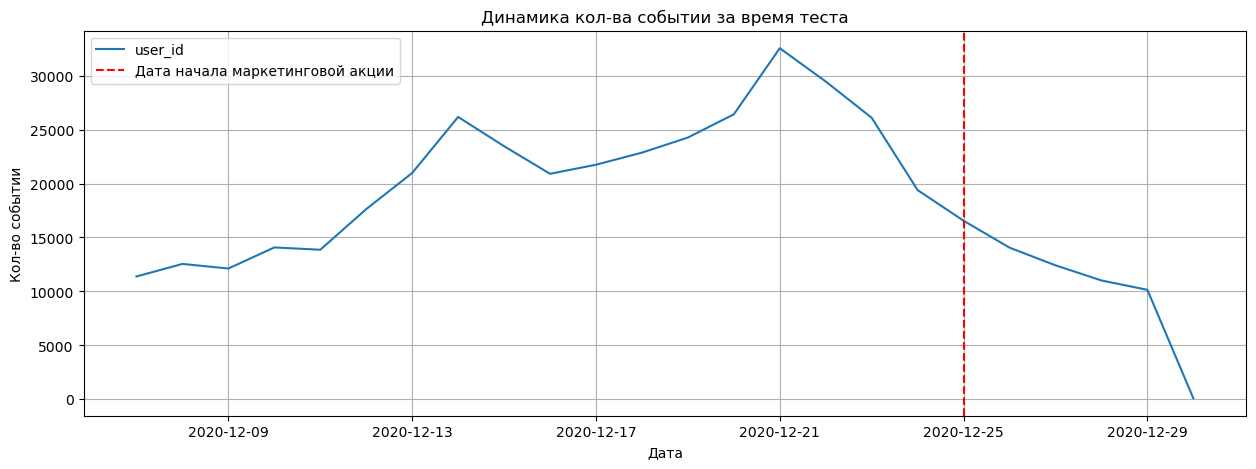

In [21]:
# смотрим как изменилась динамика событии по датам до и после начала маркетинговой активности
df_ab_events.groupby('event_dt').agg({'user_id': 'count'}
                                        ).plot(grid=True, figsize=(15, 5))
plt.axvline(x='2020-12-25', color='red', linestyle='--', label='Дата начала маркетинговой акции')

plt.title('Динамика кол-ва событии за время теста')
plt.xlabel('Дата')
plt.ylabel('Кол-во событии')
plt.legend()

plt.show()

Резких скачков в кол-ве событии после начала маркетинговой активности не заметно. Нисходящий тренд начался до старта активности, и однозначно связать это падение с маркетинговой активностью нельзя

### Лайфтайм 14 дней с момента регистрации

Выполнение каких либо дейстии клиентом - последний пункт проверки по ТЗ. До этого можем проверить насколько корректно делился трафик при регистрации клиентов на разные группы. У нас все зарегистрированные клиенты, которые попадают по датам, региону и т.д. находятся в датафрейме profiles. 

In [22]:
print(profiles.shape)
profiles.head()

(6351, 7)


,user_id,first_date,region,device,group,is_in_test_group,is_in_control_group
0,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False
1,E6DE857AFBDC6102,2020-12-07,EU,PC,B,True,False
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True
3,831887FE7F2D6CBA,2020-12-07,EU,Android,A,False,False
4,4CB179C7F847320B,2020-12-07,EU,iPhone,B,False,False


In [23]:
profiles.groupby('group')['user_id'].nunique()

group
A    3634
B    2717
Name: user_id, dtype: int64

У нас в целом набралось 6351 пользователей - участников теста.     
- Пользователи разделены на группы (A/B). Кол-во пользователей в группах сильно разнятся: в группе В на ~25% меньше пользователей чем в группе А. Распределение по группам А/В: 57,2%/42,8%.
- По всем участникам имеются одни и те же данные (метрики): даты регистрации, и целевых действии (login, - product_page, product_card, purchase), сумма покупок, тип девайса и кол-во целевых действии.     
- Клиенты в группах уникальные, т.е. не дублируются в разных группах теста.     
Далее будем смотреть на различие ключевых метрик по группам, по ТЗ ожидаемый эффект не менее 10%.

In [24]:
# добавляем данные о событиях в профили

merged_df = profiles.merge(
    df_ab_events[['user_id', 'event_dt', 'event_name', 'details']], on='user_id', how='left')

print(merged_df.shape)
merged_df.head()

(26290, 10)


,user_id,first_date,region,device,group,is_in_test_group,is_in_control_group,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False,2020-12-07,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False,2020-12-07,login,NaN
2,E6DE857AFBDC6102,2020-12-07,EU,PC,B,True,False,NaN,NaN,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-07,product_page,NaN
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-08,product_page,NaN


In [25]:
# убеждаемся что никого не потеряли на джойнах
print(merged_df['user_id'].nunique())

# рассчитываем лайфтайм для каждого события

merged_df['lifetime'] = (merged_df['event_dt'] - merged_df['first_date']).dt.days

6351


Мы убедились что все клиенты из profiles перешли в merged_df, и рассчитали лайфтайм для каждой транзакции. По лайфтайму у нас пользователи разделятся на 3 группы:
- кто не совершал активности
- кто совершал активности после тестового периода (>14 дней)
- активные в период теста

Далее в рамках исследовательского анализа, мы будем рассматривать только клиентов, которые были активны в период проведения теста. Поэтому на данном этапе нам необходимо вырезать нужные строки из merged_df, и оценить потери в каждом из групп (А/В). 
При этом, некоторые клиенты могут быть активны и в период проведения теста и после этого периода. 

In [26]:
# маркируем транзакции пользователей в разные категории

def user_group(lifetime):
    if math.isnan(lifetime):
        return 'Has no activity'
    if 0 <= lifetime < 14:
        return 'Active'
    if lifetime >= 14:
        return 'Activity is out of test'  

merged_df['user_group'] = merged_df['lifetime'].apply(user_group)

merged_df.head()

,user_id,first_date,region,device,group,is_in_test_group,is_in_control_group,event_dt,event_name,details,lifetime,user_group
0,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False,2020-12-07,product_page,NaN,0.0,Active
1,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False,2020-12-07,login,NaN,0.0,Active
2,E6DE857AFBDC6102,2020-12-07,EU,PC,B,True,False,NaN,NaN,NaN,NaN,Has no activity
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-07,product_page,NaN,0.0,Active
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-08,product_page,NaN,1.0,Active


In [27]:
# смотрим долю пользователей в разбивке по группам и категориям

pivot_df = merged_df.pivot_table(
    index='group', columns='user_group', values='user_id', aggfunc='nunique').reset_index()
pivot_df['total_count'] = pivot_df.iloc[:, 1:].sum(axis=1)

for col in pivot_df.columns[1:-1]:
    pivot_df[col + '_share'] = pivot_df[col] / pivot_df['total_count']
pivot_df

user_group,group,Active,Activity is out of test,Has no activity,total_count,Active_share,Activity is out of test_share,Has no activity_share
0,A,2604,199,1030,3833,0.679363,0.051918,0.268719
1,B,877,135,1840,2852,0.307504,0.047335,0.645161


На исследовательский анализ мы забираем 3481 пользователей
Из них в группе А - 2604, в группе В - 877 (распределение по группам А/В - 75%/25%)

Стоит отметить, что в группе А 26,8% участников теста отвалились на данном этапе из-за неактивности, в то время как в группе В этот показатель равен 64,5%.

In [28]:
df = merged_df.query('user_group == "Active"').drop(columns='user_group')
df.head()

,user_id,first_date,region,device,group,is_in_test_group,is_in_control_group,event_dt,event_name,details,lifetime
0,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False,2020-12-07,product_page,NaN,0.0
1,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False,2020-12-07,login,NaN,0.0
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-07,product_page,NaN,0.0
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-08,product_page,NaN,1.0
5,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-10,product_page,NaN,3.0


Проверить гипотезу:
<b> Распределение групп А и В равномерное, исходя из логики перехода регистрации на целевые действия </b>
    

H0: статистически значимых различий в долях перехода на целевое действие между группами нет.    
H1: отличия в  в долях перехода на целевое действие между группами есть.


**pvalue < заданной стат.значимости, группы у нас сильно различаются по поведению, именно в части перехода регистрации в выполнение целевого действия**, и возникают сомнения в правильности формирования групп на этапе разделения трафика в группы.


In [29]:
# Готовим выборки и сохраняем в переменных sample_1, sample_2
sample_1_success = df[df['group'] == 'A']['user_id'].nunique()  # кол-во совершивших целевое действие
sample_1_attempts = merged_df[merged_df['group'] == 'A']['user_id'].nunique()  # кол-во регистрации

sample_2_success = df[df['group'] == 'B']['user_id'].nunique()
sample_2_attempts = merged_df[merged_df['group'] == 'B']['user_id'].nunique() 


count = np.array([sample_1_success, sample_2_success])
nobs = np.array([sample_1_attempts, sample_2_attempts])

z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided') 

print('p-значение (prop_test):', p_value)

alpha = 0.05

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение (prop_test): 1.1445865558208e-213
Отвергаем нулевую гипотезу


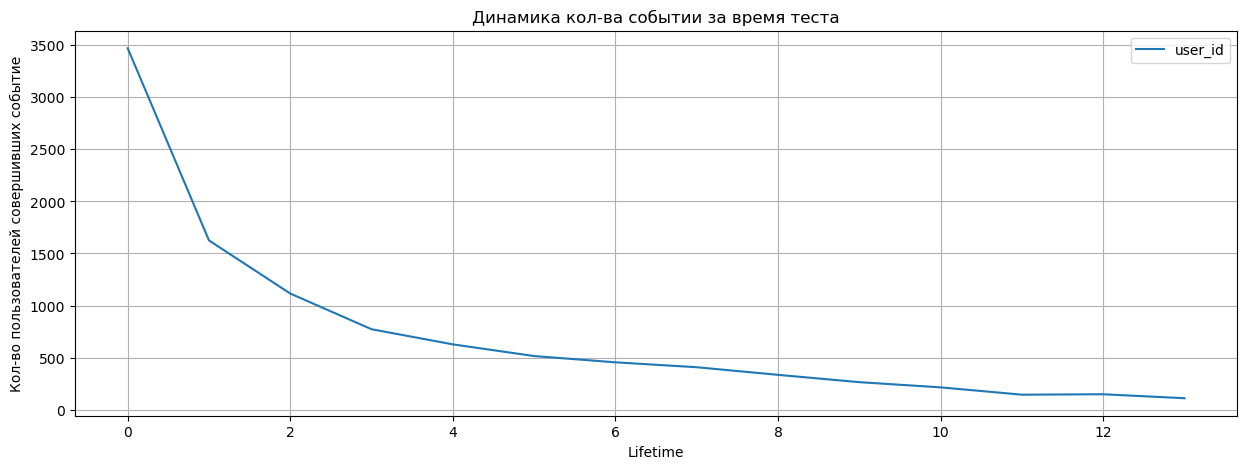

In [30]:
df.groupby(['lifetime']).agg({'user_id': 'nunique'}
                                        ).plot(grid=True, figsize=(15, 5))
plt.title('Динамика кол-ва событии за время теста')
plt.xlabel('Lifetime')
plt.ylabel('Кол-во пользователей совершивших событие')
plt.legend()

plt.show()

Из графика видно, что время принятия решения для большей части клиентов магазина меньше 7 дней. 
В начале разбора ТЗ мы заметили, что у нас не хватает части данных по событиям, в частности события за период 31.12.2020-04.01.2021. Исходя из данных графика выше, можно предположить, что это не приводит к большим потерям, учитывая что данные отсутствуют для обоих групп теста. Поэтому вырезать пользователей, по которым нет 14дневной истории мы не будем.

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Промежуточные выводы по соответствию ТЗ</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 

После проверки данных требованиям ТЗ можно отметить следующие недочеты:
- Записи по событиям неполные (не хватает данных за 31.12.2020-04.01.2021), из-за чего по части пользователей нельзя отследить 14дневную историю.
- Во время проведения теста проводились маркетинговые активности, отдельно в регионе проведения теста была одна активность. Исходя из данных нельзя заметить прямое влияние активности, поэтому данные за период активности сохранены для дальнейшего анализа. 
- Некоторые пользователи из нашей базы в период проведения теста попали в тестовую группу другого теста. Так как такие пользователи равномерно распределены в контрольной/тестовой группах, эти данные сохранены для дальнейшего исследования. 
- По кол-ву регистрации на тест мы набрали достаточную аудиторию (6000 чел, 15% из всех пользователей EU). Но для анализа конверсии мы будем брать тех, кто выполнил хоть одно целевое действие. Кол-во таких пользователей меньше, чем требуется по ТЗ. 
- Оставшаяся выборка распределена неравномерно по группам.    

**Исходя из вышеуказанного, корректность проведения теста вызывает сомнения**

## Исследовательский анализ данных

In [31]:
df.head()

,user_id,first_date,region,device,group,is_in_test_group,is_in_control_group,event_dt,event_name,details,lifetime
0,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False,2020-12-07,product_page,NaN,0.0
1,D72A72121175D8BE,2020-12-07,EU,PC,A,False,False,2020-12-07,login,NaN,0.0
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-07,product_page,NaN,0.0
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-08,product_page,NaN,1.0
5,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,False,True,2020-12-10,product_page,NaN,3.0


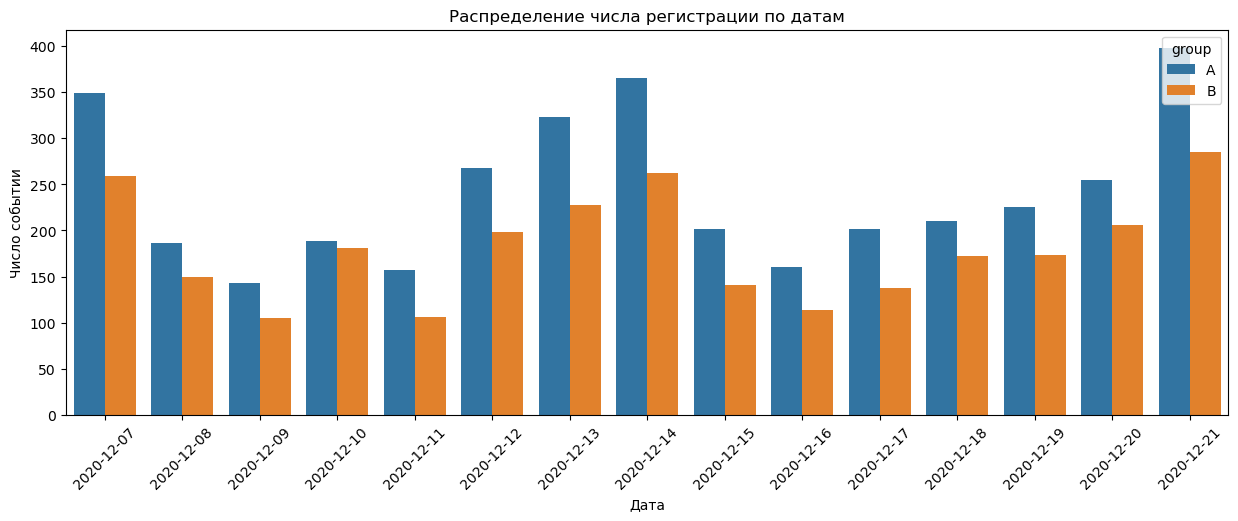

In [32]:
# смотрим распределение числа регистрации по датам

df_descr = profiles.groupby(['group', 'first_date']).agg({'user_id': ['count', 'nunique']}).reset_index()
df_descr.columns = ['group', 'first_date', 'transaction_count', 'user_count']

plt.figure(figsize=(15, 5))

sns.barplot(x='first_date', y='transaction_count', hue='group', data=df_descr)

plt.title('Распределение числа регистрации по датам')
plt.xlabel('Дата')
plt.ylabel('Число событии')
plt.legend(title='group')
plt.xticks(rotation=45) 

plt.show()

1. График по регистрациям показывает, что в сборе данных о новых регистрациях была недельная цикличность, где дни с субботы по понедельник - периоды пиковых активностей. В каждый их выделенных на сбор данных дней - в контрольную группу набиралось большее кол-во участников. Но при этом разница в высоте столбцов равномерная за все дни.  


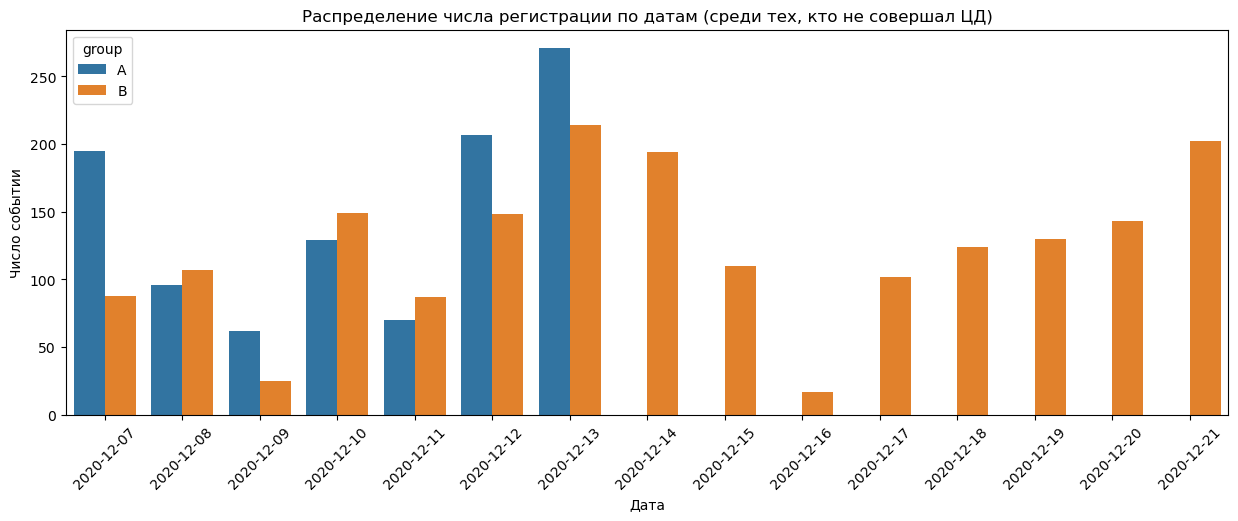

In [33]:
# смотрим распределение числа регистрации по датам (среди тех, кто не совершал ЦД)

df_descr = merged_df.query('user_group == "Has no activity"').groupby(['group', 'first_date']).agg({'user_id': ['count', 'nunique']}).reset_index()
df_descr.columns = ['group', 'first_date', 'transaction_count', 'user_count']

plt.figure(figsize=(15, 5))

sns.barplot(x='first_date', y='transaction_count', hue='group', data=df_descr)

plt.title('Распределение числа регистрации по датам (среди тех, кто не совершал ЦД)')
plt.xlabel('Дата')
plt.ylabel('Число событии')
plt.legend(title='group')
plt.xticks(rotation=45) 

plt.show()

2. Один из важных графиков - **распределение числа регистрации по датам (среди тех, кто не совершал ЦД)** показывает, что в сборе данных были допущены критические ошибки, т.к. со второй недели сбора новых участников для группы А кол-во новых участников было равно кол-ву логинов в интернет магазине, в то время как у группы В большая доля клиентов так и не доходили до совершения целевого действия (login). Так как в первую неделю сборов поведение участников групп А/В были одинаковые, и что они резко изменились начиная со второй недели, показывает на изменение параметров набора новых участников в контрольной группе.


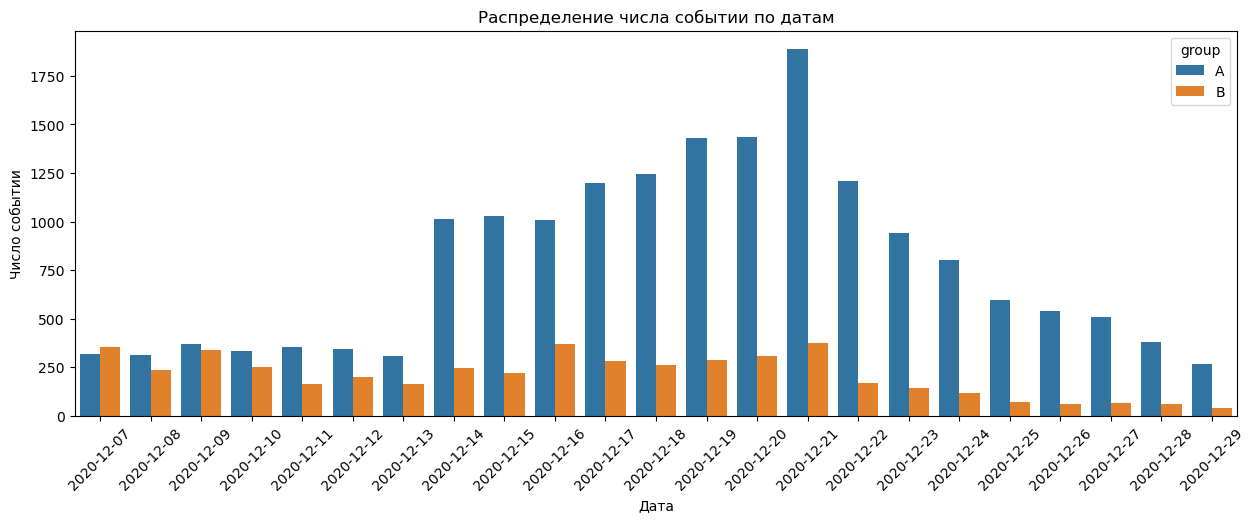

In [34]:
# смотрим распределение числа событии по датам

df_descr = df.groupby(['group', 'event_dt']).agg({'user_id': ['count', 'nunique']}).reset_index()
df_descr.columns = ['group', 'event_dt', 'transaction_count', 'user_count']

plt.figure(figsize=(15, 5))

sns.barplot(x='event_dt', y='transaction_count', hue='group', data=df_descr)

plt.title('Распределение числа событии по датам')
plt.xlabel('Дата')
plt.ylabel('Число событии')
plt.legend(title='group')
plt.xticks(rotation=45) 

plt.show()

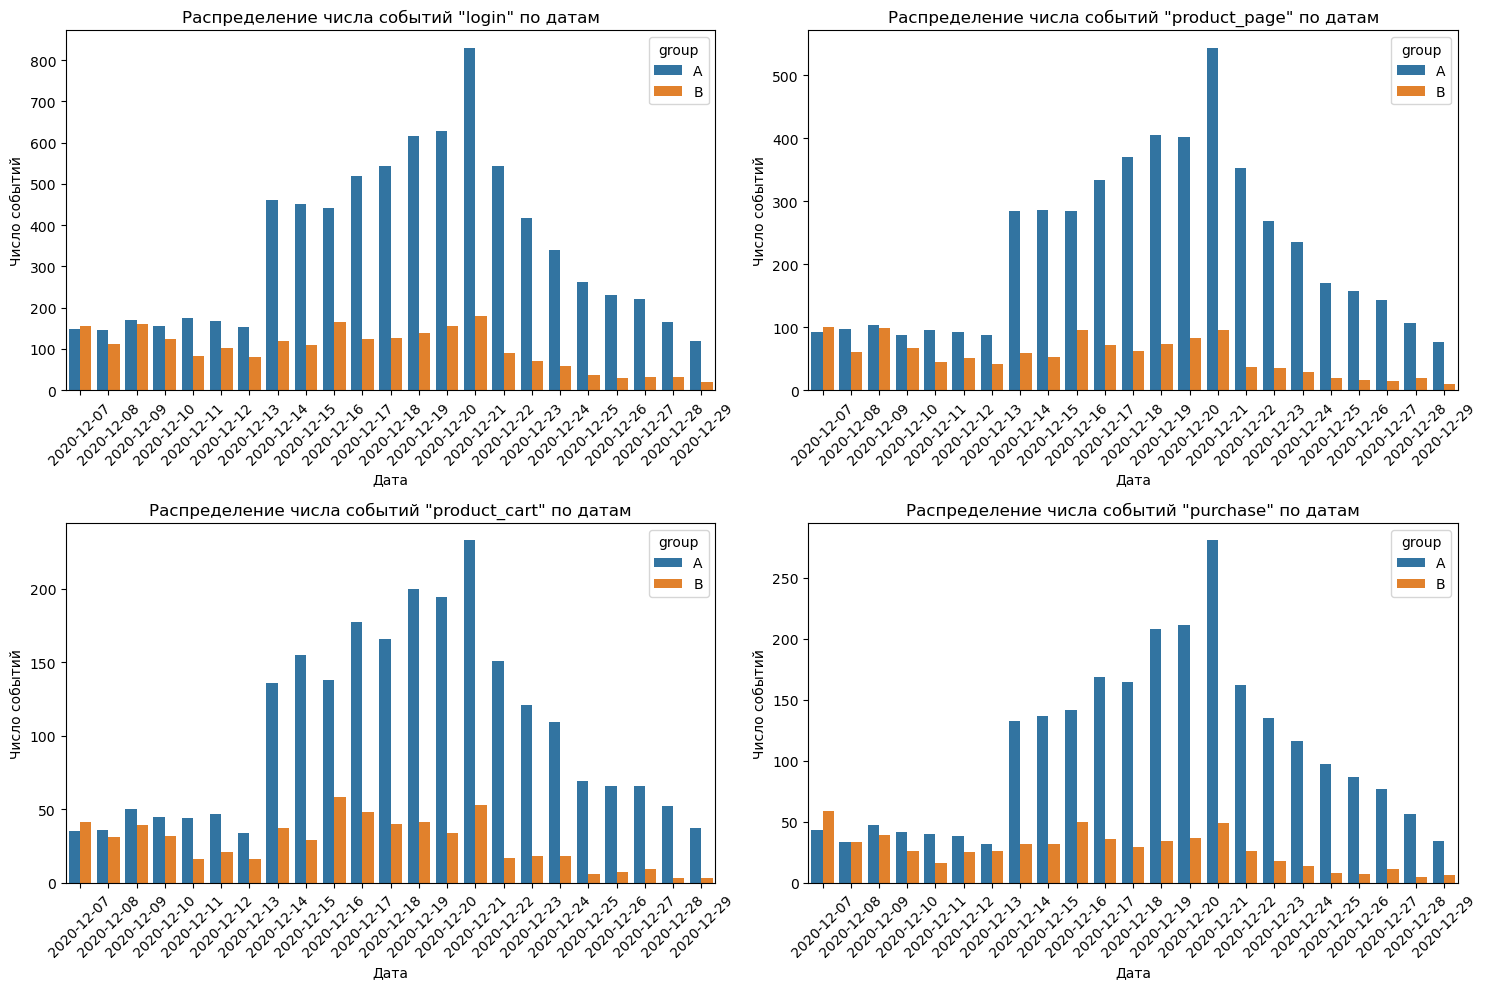

In [35]:
# смотрим распределение всех событии по датам

actions = ['login', 'product_page', 'product_cart', 'purchase']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for action, ax in zip(actions, axes.flatten()):
    df_desc = df.query(f'event_name == "{action}"'
                      ).groupby(['group', 'event_dt']).agg({'user_id': ['count', 'nunique']}).reset_index()
    
    df_desc.columns = ['group', 'event_dt', 'transaction_count', 'user_count'] 

    sns.barplot(x='event_dt', y='transaction_count', hue='group', data=df_desc, ax=ax)
    
    ax.set_title(f'Распределение числа событий "{action}" по датам')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Число событий')
    ax.legend(title='group')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout() 
plt.show()



3. График распределения числа событии по датам - сначала рассмотрели распределение суммы всех событии в разрезе групп (А/В), далее каждый этап события по отдельности, так же в разбивке по группам. Графики показывают, что резкое изменение в кол-ве событии группы А затронуло все этапы воронки (участники не только больше логинятся, но и просмотры товаров/корзины и покупки показали равнозначное увеличение). Это может говорить о том, что с 14 декабря в число новых регистрации в группе А стали попадать только те, кто логинился на сайте, в то время как в группе В часть клиентов могли покинуть сайт без логина (в первую неделю набора участников в обоих группах часть трафика могла покинуть сайт без регистрации). 

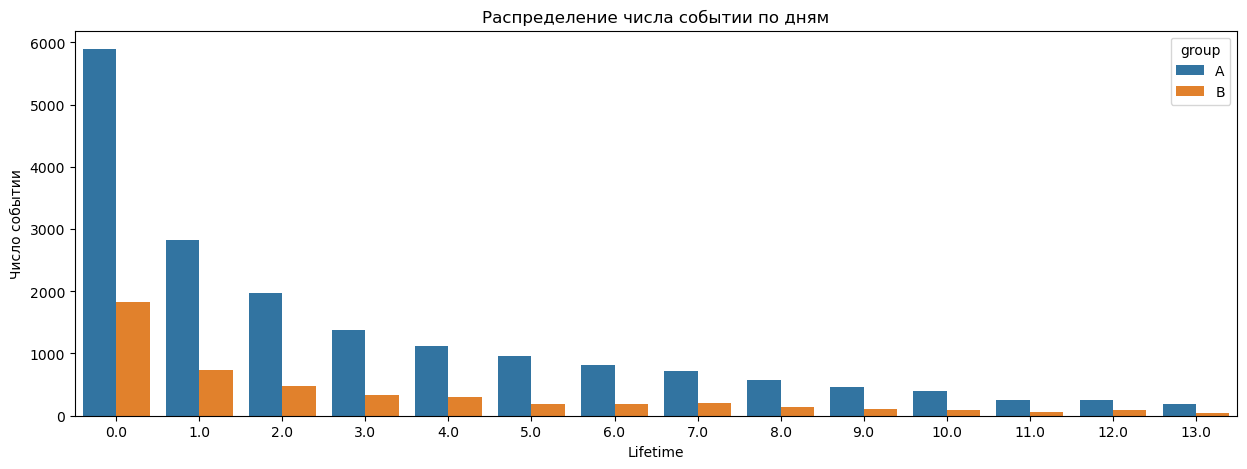

In [36]:
# смотрим распределение числа событии по дням

df_descr = df.groupby(['group', 'lifetime']).agg({'user_id': ['count', 'nunique']}).reset_index()
df_descr.columns = ['group', 'lifetime', 'transaction_count', 'user_count']

plt.figure(figsize=(15, 5))

sns.barplot(x='lifetime', y='transaction_count', hue='group', data=df_descr)

plt.title('Распределение числа событии по дням')
plt.xlabel('Lifetime')
plt.ylabel('Число событии')
plt.legend(title='group')

plt.show()

Из графика видно, что время принятия решения для большей части клиентов магазина меньше 4 дней. Поведение клиентов контрольной и тестовой группы схожие.


**Распределение пользователей по кол-ву событии**

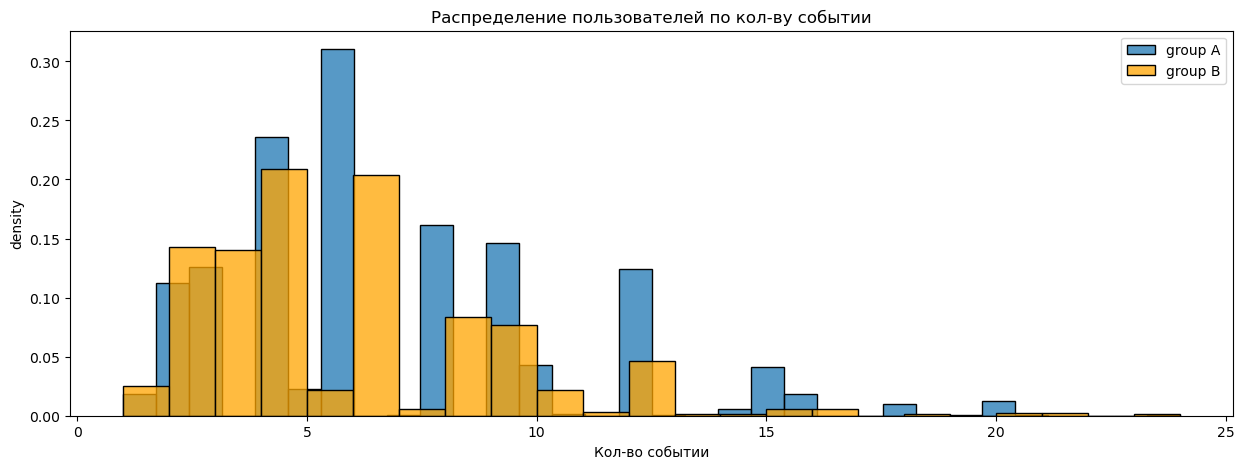

In [37]:
# Распределение пользователей по кол-ву событии

plt.figure(figsize=(15, 5))
sns.histplot(df[df['group'] == 'A'].groupby(['user_id'])['event_dt'].count(), common_norm=False, stat="density")
sns.histplot(df[df['group'] == 'B'].groupby(['user_id'])['event_dt'].count(), color="orange", common_norm=False, stat="density")

plt.title('Распределение пользователей по кол-ву событии')
plt.xlabel('Кол-во событии')
plt.ylabel('density')

plt.legend(["group A", "group B"])
plt.show()


**Распределение пользователей по кол-ву событии**

- График показывает распределение кол-ва событии на пользователя. Т.е. как часто в выборке встречаются участники совершившие n событии. Форма распределения у групп схожие, но при этом распределение контрольной группы смещена вправо в отношении тестовой группы. Это может означать что при равном кол-во логинов, конверсия в следующие шаги у контрольной группы будет выше чем у тестовой. Пока сложно понять какие шаги совершаются чаще, детально сможем увидеть на этапе построения воронки.

In [38]:
# считаем среднее число событий на пользователя среди всех зарегистрировавшихся

df_descr = merged_df.groupby('group').agg({'user_id': ['count', 'nunique']}).reset_index()
df_descr.columns = ['group', 'transaction_count', 'user_count']
df_descr['avg_tr_per_user'] = df_descr['transaction_count'] / df_descr['user_count']
df_descr

,group,transaction_count,user_count,avg_tr_per_user
0,A,19339,3634,5.321684
1,B,6951,2717,2.558336


In [39]:
# считаем среднее число событий на пользователя среди тех, кто совершал ЦД (целевое действие)

df_descr = df.groupby('group').agg({'user_id': ['count', 'nunique']}).reset_index()
df_descr.columns = ['group', 'transaction_count', 'user_count']
df_descr['avg_tr_per_user'] = df_descr['transaction_count'] / df_descr['user_count']
display(df_descr)

,group,transaction_count,user_count,avg_tr_per_user
0,A,17835,2604,6.849078
1,B,4785,877,5.456100


In [40]:
# считаем среднюю сумму покупок на пользователя среди тех, кто совершал ЦД (целевое действие)

df_descr = df[df['details'].isna()==False].groupby('group').agg({'user_id': ['count', 'nunique'], 'details': ['sum', 'mean']}).reset_index()
df_descr.columns = ['group', 'transaction_count', 'user_count', 'purchases', 'avg_sum_per_transaction']
df_descr['avg_sum_per_user'] = round(df_descr['purchases'] / df_descr['user_count'], 2)
df_descr

,group,transaction_count,user_count,purchases,avg_sum_per_transaction,avg_sum_per_user
0,A,2485,833,57435.15,23.112736,68.95
1,B,618,249,14233.82,23.032071,57.16


**Среднее кол-во событии на пользователя**

Среднее кол-во было рассчитано среди тех, кто совершал ЦД (целевое действие),  и среди всех зарегистрировавшихся. Как и отмечали ранее в описании графиков, увидели следующие особенности:
- По разнице в среднем кол-во событии на каждого *зарегистрировавшегося* заметно что в тестовой группе большая доля участников без событии. 
- Среднее кол-во событии на пользователя в контрольной группе больше чем в тестовой. 
- Средняя сумма на транзакцию у групп одинаковые (~€23), а средний чек на покупателя у контрольной группы выше. Что так же свидетельствует в пользу того, что клиенты в контрольной группе совершают больше событии за одинаковый период времени.

In [41]:
df['device'].value_counts()

Android    9903
PC         5798
iPhone     4719
Mac        2200
Name: device, dtype: int64

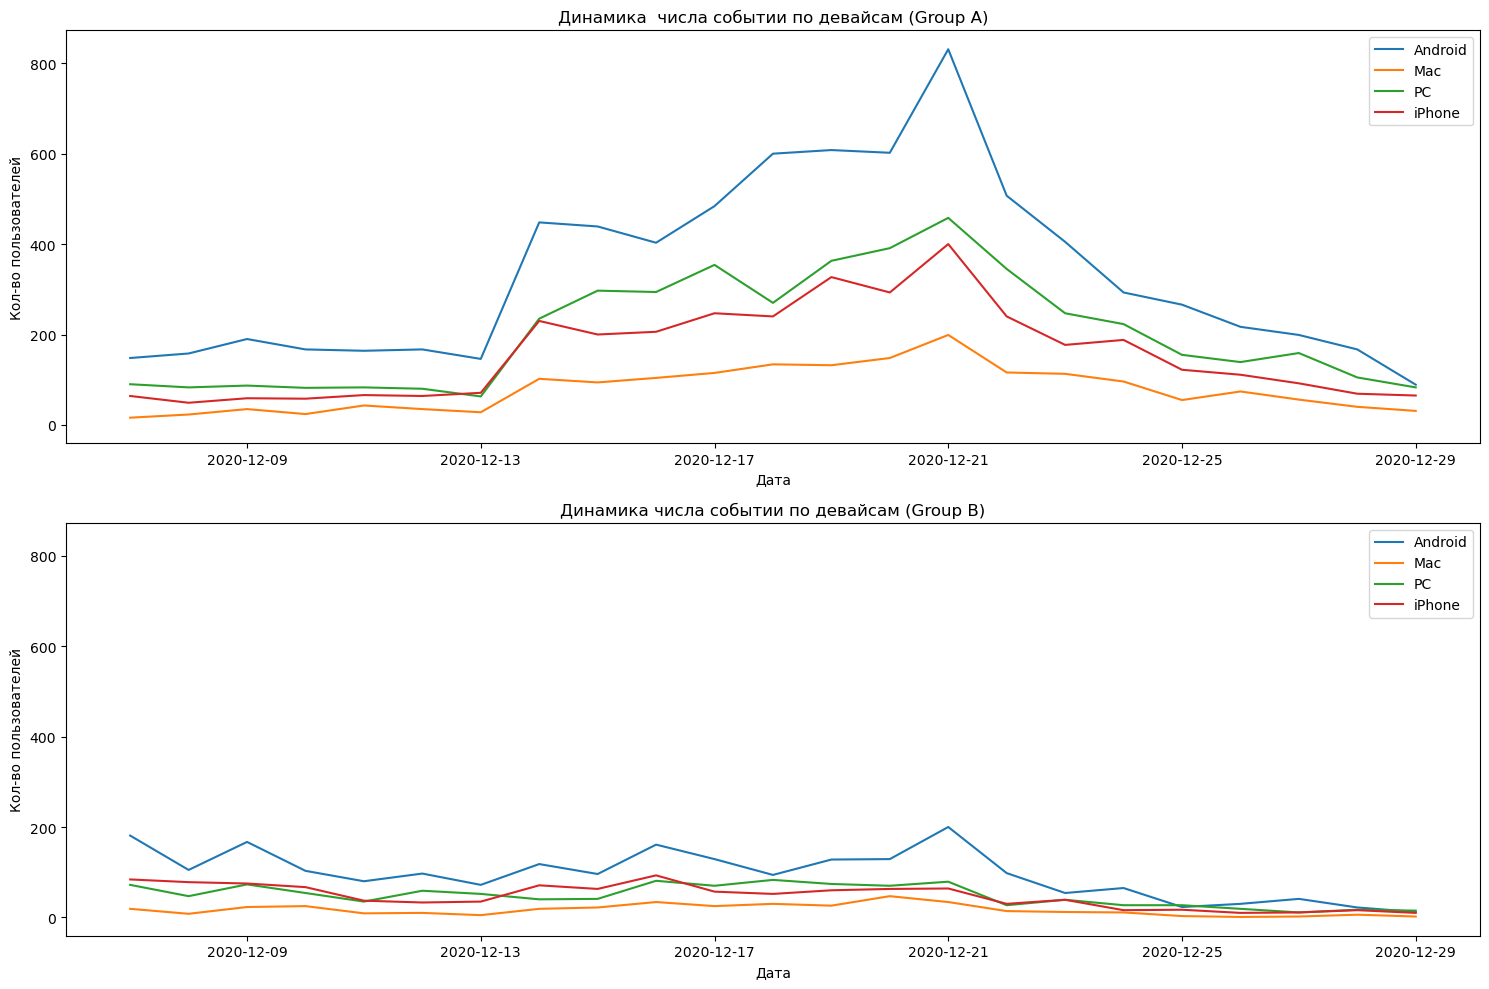

In [42]:
# Cмотрим распределение числа событии по девайсам

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharey=True)

# распределение группы A
df_descr_a = df.query('group == "A"').groupby(['device', 'event_dt']).agg({'user_id': ['count', 'nunique']}).reset_index()
df_descr_a.columns = ['device', 'event_dt', 'transaction_count', 'user_count']

sns.lineplot(x='event_dt', y='transaction_count', hue='device', data=df_descr_a, ax=axes[0])
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Кол-во пользователей')
axes[0].set_title('Динамика  числа событии по девайсам (Group A)')
axes[0].legend()

# распределение группы B
df_descr_b = df.query('group == "B"').groupby(['device', 'event_dt']).agg({'user_id': ['count', 'nunique']}).reset_index()
df_descr_b.columns = ['device', 'event_dt', 'transaction_count', 'user_count']

sns.lineplot(x='event_dt', y='transaction_count', hue='device', data=df_descr_b, ax=axes[1])
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Кол-во пользователей')
axes[1].set_title('Динамика числа событии по девайсам (Group B)')
axes[1].legend()

plt.tight_layout() 
plt.show()


**Динамика числа событии по девайсам**

- Поведения клиентов контрольной и тестовой группы в разбивке по девайсам схожие. Больше всего действии производилось с Android, меньше всего с MAC. При этом доли девайсов остаются стабильными за весь период отслеживания событии

## Продуктовая воронка, анализ конверсии

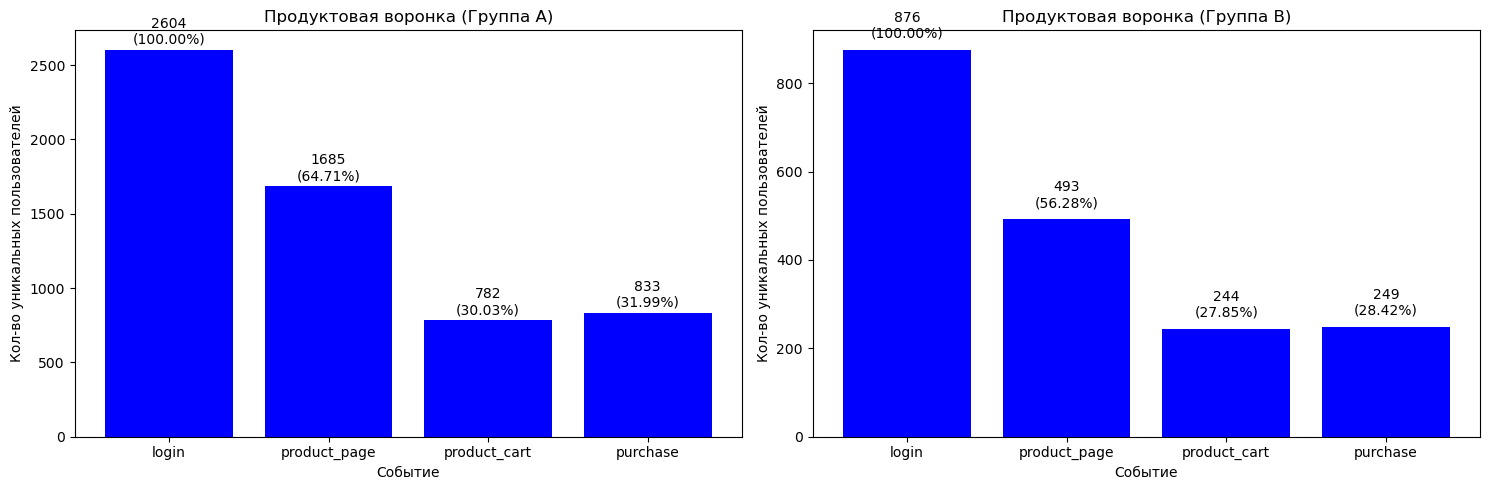

In [43]:
group_names = ['A', 'B']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, group_name in enumerate(group_names):
    funnel_df = df.query(f'group == "{group_name}"').groupby('event_name')['user_id'].nunique().reset_index()
    funnel_df.columns = ['event_name', 'event_count']

    event_names = funnel_df['event_name']
    event_counts = funnel_df['event_count']

    step_percentages = [count / event_counts[0] * 100 for count in event_counts]

    # Задаем корректный порядок действий 
    custom_order = ['login', 'product_page', 'product_cart', 'purchase']

    sorted_data = sorted(zip(event_names, event_counts, step_percentages), key=lambda x: custom_order.index(x[0]))
    sorted_event_names, sorted_event_counts, sorted_step_percentages = zip(*sorted_data)

    ax = axes[i]

    bars = ax.bar(sorted_event_names, sorted_event_counts, color='blue')

    for j, (count, percentage) in enumerate(zip(sorted_event_counts, sorted_step_percentages)):
        ax.text(j, count + 20, f"{count}\n({percentage:.2f}%)", ha='center', va='bottom')

    ax.set_xlabel('Событие')
    ax.set_ylabel('Кол-во уникальных пользователей')
    ax.set_title(f'Продуктовая воронка (Группа {group_name})')

plt.tight_layout()      
plt.show()


**Воронка событии, анализ конверсии**

Мы построили воронки событии для контрольной и тестовой группы. В ходе анализа стало ясно, что **события в воронке не цепные (не последовательные), и клиенты могут пропускать какие то этапы**, и например сразу после логина совершить покупку. В визуализации мы построили воронку исходя из логической последовательности действии, и конверсию считали от начального шага воронки (login). **В воронке на каждом этапе указаны кол-во уникальных клиентов, совершавших действия данного этапа. **

Как и предпологали на этапе анализа кол-ва событии на пользователя, конверсия в контрольной группе лучше конверсии тестовой группы. Исходя из этого, можно сразу отметить что **ожидаемый эффект от новой рекомендательной системы не достигнут.**

*ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%*

конверсии в просмотр карточек товаров — событие product_page:    
    - Контрольная группа - 64,7    
    - Тестовая группа - 56,3%    
    
просмотры корзины — product_cart:    
    - Контрольная группа - 30%    
    - Тестовая группа - 28%    

покупки — purchase    
    - Контрольная группа - 32%    
    - Тестовая группа - 28,4%    
 

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Промежуточные выводы по исследовательскому анализу</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 

**Распределения числа событии по датам**

1. Один из важных графиков - **распределение числа регистрации по датам (среди тех, кто не совершал ЦД)** показывает, что в сборе данных были допущены критические ошибки, т.к. со второй недели сбора новых участников для группы А кол-во новых участников было равно кол-ву логинов в интернет магазине, в то время как у группы В большая доля клиентов так и не доходили до совершения целевого действия (login). Так как в первую неделю сборов поведение участников групп А/В были одинаковые, и что они резко изменились начиная со второй недели, показывает на изменение параметров набора новых участников в контрольной группе.

3. График распределения числа событии по датам - сначала рассмотрели распределение суммы всех событии в разрезе групп (А/В), далее каждый этап события по отдельности, так же в разбивке по группам. Графики показывают, что резкое изменение в кол-ве событии группы А затронуло все этапы воронки (участники не только больше логинятся, но и просмотры товаров/корзины и покупки показали равнозначное увеличение). Это может говорить о том, что с 14 декабря в число новых регистрации в группе А стали попадать только те, кто логинился на сайте, в то время как в группе В часть клиентов могли покинуть сайт без логина (в первую неделю набора участников в обоих группах часть трафика могла покинуть сайт без регистрации). 

**Распределения числа событии по дням**

- Из графика видно, что время принятия решения для большей части клиентов магазина меньше 7 дней. Поведение клиентов контрольной и тестовой группы схожие.


**Распределение пользователей по кол-ву событии**

- График показывает распределение кол-ва событии на пользователя. Т.е. как часто в выборке встречаются участники совершившие n событии. Форма распределения у групп схожие, но при этом распределение контрольной группы смещена вправо в отношении тестовой группы. Это может означать что при равном кол-во логинов, конверсия в следующие шаги у контрольной группы будет выше чем у тестовой. Пока сложно понять какие шаги совершаются чаще, детально сможем увидеть на этапе построения воронки.

**Среднее кол-во событии на пользователя**

Среднее кол-во было рассчитано среди тех, кто совершал ЦД (целевое действие),  и среди всех зарегистрировавшихся. Как и отмечали ранее в описании графиков, увидели следующие особенности:
- По разнице в среднем кол-во событии на каждого *зарегистрировавшегося* заметно что в тестовой группе большая доля участников без событии. 
- Среднее кол-во событии на пользователя в контрольной группе больше чем в тестовой. 
- Средняя сумма на транзакцию у групп одинаковые (~€23), а средний чек на покупателя у контрольной группы выше. Что так же свидетельствует в пользу того, что клиенты в контрольной группе совершают больше событии за одинаковый период времени.

**Анализ конверсии**
Конверсия в контрольной группе лучше конверсии тестовой группы. Исходя из этого, ожидаемый эффект от новой рекомендательной системы не достигнут.
        
*ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%*

конверсии в просмотр карточек товаров — событие product_page:    
    - Контрольная группа - 64,7    
    - Тестовая группа - 56,3%    
    
просмотры корзины — product_cart:    
    - Контрольная группа - 30%    
    - Тестовая группа - 28%    

покупки — purchase    
    - Контрольная группа - 32%    
    - Тестовая группа - 28,4%    
 

## Статистический тест

У нас есть 3 события, где необходимо проверить улучшение метрик. Нам необходимо сравнить долю пользователей в каждой группе, совершившие данные события. Для этого используем proportions_ztest, и оценим является ли отличие в пропорциях между группами статистически значимыми;

**H0:** различия между пропорциями статистически не значима    
**H1:** различия между пропорциями статистически значима

Так как с каждой новой проверкой гипотезы растет вероятность ложнопозитивной ошибки, необходимо ввести поправку к уровню значимости. Применим поправку Бонферрони: alpha = 0.05 / 3 = 0.016

In [44]:
# Приведем данные в нужный формат, где шаг login - attempts, остальные шаги successes

df_pivot = df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique'
              ).reset_index().reindex([0, 2, 1, 3]).reset_index(drop=True)
df_pivot['total'] = df_pivot['A'] + df_pivot['B']
df_pivot

group,event_name,A,B,total
0,login,2604,876,3480
1,product_page,1685,493,2178
2,product_cart,782,244,1026
3,purchase,833,249,1082


In [45]:
# проверяем разницу в конверсии от начального этапа воронки

df_pivot['p-value'] = df_pivot.apply(lambda row: proportions_ztest(
    np.array([row['A'], row['B']]),
    np.array([df_pivot.loc[0, 'A'],df_pivot.loc[0, 'B']])
)[1], axis=1)


df_pivot


/Users/uliyam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


group,event_name,A,B,total,p-value
0,login,2604,876,3480,NaN
1,product_page,1685,493,2178,0.000008
2,product_cart,782,244,1026,0.221594
3,purchase,833,249,1082,0.048648


Пропорции в просмотр карточек товаров (product_page) — отличаются у групп.    
pvalue < alpha. Вероятность получить подобное (или больше) отличие равна 0.000008. Такая разница в пропорциях при указанных размерах выборок достаточна, чтобы говорить о статистически значимом различии на данном этапе воронки. 

Пропорции в просмотр корзины (product_cart) и в покупки (purchase) у тестовой и контрольной группы не сильно отличаются, т.к. pvalue > alpha. Вероятность получить подобное (или больше) отличие равна 22% и 4.8% соответственно. Это достаточная вероятность, чтобы делать вывод о значимом различии в конверсии групп, учитывая наш уровень alpha=1,6%

Следовательно, отвергаем нулевую гипотезу о равенстве долей для события product_page;     
И не удалось отвергнуть нулевую гипотезу для событии просмотры корзины — product_cart, и покупки — purchase. На этих этапаз выборки не имеют статистически значимых различии. 

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Выводы</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 

В рамках анализа все задачи были выполнены. 
        
- Мы проверили данные на соответствие с ТЗ. В ходе этого анализа были выявлены некоторые недочеты в корректности проведения теста:
        - неполные данные по событиям
        - возможное влияние маркетинговых акции и параллельно проводимых тестов
        - неравномерное распределение участников между контрольным и тестовым группами
        - недостаточный объем базы
        
- Следующим этапом был проведен исследователький анализ данных (EDA), в ходе которого выяснили:
        - в сборе данных были допущены критические ошибки. С 14 декабря в число новых регистрации в группе А стали попадать только те, кто логинился на сайте, в то время как в группе В часть клиентов могли покинуть сайт без логина (в первую неделю набора участников в обоих группах часть трафика могла покинуть сайт без авторизации). Это привело к неравномерному распределению участников между контрольным и тестовым группами
        - Графики распределения числа событии по датам показывают, что резкое изменение в кол-ве событии группы А затронуло все этапы воронки (участники не только больше логинятся, но и просмотры товаров/корзины и покупки показали равнозначное увеличение). Соответственно, данная ошибка привела к неравномерному распределению участников в группах, но не вызвало перекосов в конверсии на этапах воронки. 
        - График распределения кол-ва событии на пользователя и средние значения кол-ва действии и суммы заказа показало что при равном кол-во логинов, конверсия в следующие шаги у контрольной группы будет выше чем у тестовой.

        
Построив воронку действии и посчитав конверсию в группах выявили что конверсия в контрольной группе лучше конверсии тестовой группы. **Ожидаемый эффект от новой рекомендательной системы - улучшение каждой из метрик на 10% - не достигнут.**
конверсии в просмотр карточек товаров — событие product_page:    
    - Контрольная группа - 64,7    
    - Тестовая группа - 56,3%    
    
просмотры корзины — product_cart:    
    - Контрольная группа - 30%    
    - Тестовая группа - 28%    

покупки — purchase    
    - Контрольная группа - 32%    
    - Тестовая группа - 28,4%    
        
Суммируя всю работу, можно сказать что в проведении теста были допущены много ошибок, одна из них привела к разным методам набора участников в контрольную и тестовую группу. Но, так как эта разность методов затронула все этапы анализируемой воронки, а не отдельные ее шаги, по проведенной работе можно получить результаты по тесту новой рекомендательной системы.  
Мы оценили пропорции пользователей в каждой группе, совершившие целевые события, и ни в одном из событии не зафиксировали улучшения метрик в группе В относительно группы А. Следовательно, тест можно остановить, и принять решение о нецелесообразности применения новой рекомендательной системы для всей базы.
